# Model Selection

Using cross-validation:
- Create K random train-test splits, where the evaluation metric is averaged across splits
- This leads to models that are more reliable to unseen data
- We can also use GridSearchCv method within each cross-validation fold
- However, using only cross-validation or a test set to do model selection may lead to more subtle overfitting/optimistic generalization estimates

## Training, Validation and Test Framework for Model Selection and Evaluation
1. Training set (model building)
2. Validation set (model selection)
3. Test set (final evaluation)

In practice:
- Create an initial training/test split
- Do cross-validation on the training data for model/parameter selection
- Save the held-out test set for final model evaluation

## Extra notes
- Accuracy is often not the right evaluation metric for many real-world machine learning tasks
    - False positives and false negatives may need to be treated very differently
- Examples of additional evaluation methods
    - **Learning curve**: How much does accuracy (or other metric) chance as a function of the amount of training data?
    - **Sensitivity analysis**: How much does accuracy (or other metric) change as a function of key learning parameter values?

[Metrics for model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)

## Cross-validation example

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

dataset = load_digits()
# again, making this a binary problem with 'digit 1' as positive class 
# and 'not 1' as negative class
X, y = dataset.data, dataset.target == 1
clf = SVC(kernel='linear', C=1)

# accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=5, scoring = 'roc_auc'))
# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall'))

Cross-validation (accuracy) [0.91944444 0.98611111 0.97214485 0.97493036 0.96935933]
Cross-validation (AUC) [0.9641871  0.9976571  0.99372205 0.99699002 0.98675611]
Cross-validation (recall) [0.81081081 0.89189189 0.83333333 0.83333333 0.83333333]


## Grid Search Example

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = SVC(kernel='rbf')
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Grid best parameter (max. accuracy):  {'gamma': 0.001}
Grid best score (accuracy):  0.9985157648354676
Test set AUC:  0.99982858122393
Grid best parameter (max. AUC):  {'gamma': 0.001}
Grid best score (AUC):  1.0


## Two-feature classification example using the digits dataset

### Optimizing a classifier using different evaluation metrics

- Precision oriented -> Tries to reduce false positives while increasing true positives
- Recall oriented -> Tries to reduce false negatives while increasing true positives
- F1 oriented -> Between precision and recall as it is the harmonic mean of both
- AUC oriented -> similar decision boundary to F1 oriented, but slightly shifted towards Recall oriented

Grid best parameter (max. precision): {'class_weight': {1: 2}}
Grid best score (precision): 0.5292619047619047
Grid best parameter (max. recall): {'class_weight': {1: 50}}
Grid best score (recall): 0.9214285714285714
Grid best parameter (max. f1): {'class_weight': {1: 3}}
Grid best score (f1): 0.5418181818181818
Grid best parameter (max. roc_auc): {'class_weight': {1: 4}}
Grid best score (roc_auc): 0.8933671058812515


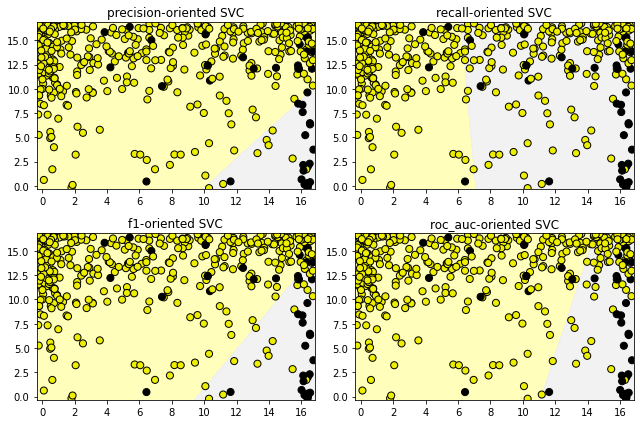

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from utils.adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a two-feature input vector matching the example plot above
# We jitter the points (add a small amount of random noise) in case there are areas
# in feature space where many instances have the same features.
jitter_delta = 0.25
X_twovar_train = X_train[:,[20,59]]+ np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test  = X_test[:,[20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = SVC(kernel = 'linear').fit(X_twovar_train, y_train)
grid_values = {'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20},{1:50}]}
plt.figure(figsize=(9,6))
for i, eval_metric in enumerate(('precision','recall', 'f1','roc_auc')):
    grid_clf_custom = GridSearchCV(clf, param_grid=grid_values, scoring=eval_metric)
    grid_clf_custom.fit(X_twovar_train, y_train)
    print('Grid best parameter (max. {0}): {1}'
          .format(eval_metric, grid_clf_custom.best_params_))
    print('Grid best score ({0}): {1}'
          .format(eval_metric, grid_clf_custom.best_score_))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plot_class_regions_for_classifier_subplot(grid_clf_custom, X_twovar_test, y_test, None,
                                             None, None,  plt.subplot(2, 2, i+1))
    
    plt.title(eval_metric+'-oriented SVC')
plt.tight_layout()
plt.show()

- Yellow dots -> Negatives
- Black dots -> Positives

### Precision-recall curve for the default SVC classifier (with balanced class weights)

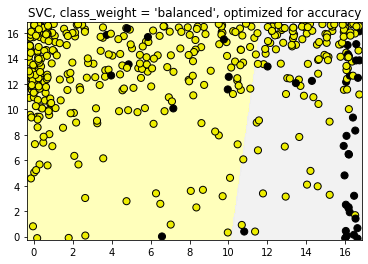

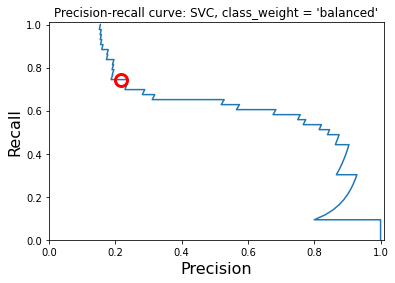

At zero threshold, precision: 0.22, recall: 0.74


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from utils.adspy_shared_utilities import plot_class_regions_for_classifier
from sklearn.svm import SVC

dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# create a two-feature input vector matching the example plot above
jitter_delta = 0.25
X_twovar_train = X_train[:,[20,59]]+ np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test  = X_test[:,[20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = SVC(kernel='linear', class_weight='balanced').fit(X_twovar_train, y_train)

y_scores = clf.decision_function(X_twovar_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

fig = plot_class_regions_for_classifier(clf, X_twovar_test, y_test, title = "SVC, class_weight = 'balanced', optimized for accuracy")

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title ("Precision-recall curve: SVC, class_weight = 'balanced'")
plt.plot(precision, recall, label = 'Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize=12, fillstyle='none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()
print('At zero threshold, precision: {:.2f}, recall: {:.2f}'
      .format(closest_zero_p, closest_zero_r))